© 2025 Mobile Perception Systems Lab at TU/e. All rights reserved. Licensed under the MIT License.

## Setup

In [1]:
import yaml
from lightning import seed_everything
import torch
from torch.nn import functional as F
from torch.amp.autocast_mode import autocast
import matplotlib.pyplot as plt
import numpy as np
from huggingface_hub import hf_hub_download
from huggingface_hub.utils import RepositoryNotFoundError
import warnings
import importlib

seed_everything(0, verbose=False)

device = 0  # TODO: change to the GPU you want to use
img_idx = 0  # TODO: change to the index of the image you want to visualize
config_path = "configs/coco/panoptic/eomt_giant_1280.yaml"  # TODO: change to the config file
data_path = "/mnt/sda1/tkerssies"  # TODO: change to the dataset directory

with open(config_path, "r") as f:
    config = yaml.safe_load(f)


def create_mapping(images, ignore_index):
    unique_ids = np.unique(np.concatenate([np.unique(img) for img in images]))
    valid_ids = unique_ids[unique_ids != ignore_index]
    colors = np.array([plt.cm.hsv(i / len(valid_ids))[:3] for i in range(len(valid_ids))])
    mapping = {cid: colors[i] for i, cid in enumerate(valid_ids)}
    mapping[ignore_index] = np.array([0, 0, 0])
    return mapping


def apply_colormap(image, mapping):
    colored_image = np.zeros((*image.shape, 3))
    for cid in np.unique(image):
        colored_image[image == cid] = mapping.get(cid, [0, 0, 0])
    return colored_image

## Load dataset

Ensure the dataset files are correctly prepared and placed in the folder specified by `data_path`.

In [2]:
data_module_name, class_name = config["data"]["class_path"].rsplit(".", 1)
data_module = getattr(importlib.import_module(data_module_name), class_name)
data_module_kwargs = config["data"].get("init_args", {})

data = data_module(
    path=data_path,
    batch_size=1,
    num_workers=0,
    check_empty_targets=False,
    **data_module_kwargs
).setup()

## Load model

In [3]:
warnings.filterwarnings(
    "ignore",
    message=r".*Attribute 'network' is an instance of `nn\.Module` and is already saved during checkpointing.*",
)

# Load encoder
encoder_cfg = config["model"]["init_args"]["network"]["init_args"]["encoder"]
encoder_module_name, encoder_class_name = encoder_cfg["class_path"].rsplit(".", 1)
encoder_cls = getattr(importlib.import_module(encoder_module_name), encoder_class_name)
encoder = encoder_cls(img_size=data.img_size, **encoder_cfg.get("init_args", {}))

# Load network
network_cfg = config["model"]["init_args"]["network"]
network_module_name, network_class_name = network_cfg["class_path"].rsplit(".", 1)
network_cls = getattr(importlib.import_module(network_module_name), network_class_name)
network_kwargs = {
    k: v for k, v in network_cfg["init_args"].items() if k != "encoder"
}
network = network_cls(
    masked_attn_enabled=False,
    num_classes=data.num_classes,
    encoder=encoder,
    **network_kwargs,
)

# Load Lightning module
lit_module_name, lit_class_name = config["model"]["class_path"].rsplit(".", 1)
lit_cls = getattr(importlib.import_module(lit_module_name), lit_class_name)
model_kwargs = {
    k: v for k, v in config["model"]["init_args"].items() if k != "network"
}
if "stuff_classes" in config["data"].get("init_args", {}):
    model_kwargs["stuff_classes"] = config["data"]["init_args"]["stuff_classes"]

model = (
    lit_cls(
        img_size=data.img_size,
        num_classes=data.num_classes,
        network=network,
        **model_kwargs,
    )
    .eval()
    .to(device)
)

## Load pre-trained weights from Hugging Face Hub
The model weights are downloaded from the Hugging Face Hub using the logger name from the config. Make sure you have a working internet connection.

In [4]:
name = config.get("trainer", {}).get("logger", {}).get("init_args", {}).get("name")

if name is None:
    warnings.warn("No logger name found in the config. Please specify a model name.")
else:
    try:
        state_dict_path = hf_hub_download(
            repo_id=f"tue-mps/{name}",
            filename="pytorch_model.bin",
        )
        state_dict = torch.load(
            state_dict_path, map_location=torch.device(f"cuda:{device}"), weights_only=True
        )
        model.load_state_dict(state_dict)
    except RepositoryNotFoundError:
        warnings.warn(f"Pre-trained model not found for `{name}`. Please load your own checkpoint.")

## Semantic inference (pixel-wise classification)

> This inference method also works when applied to a model trained for panoptic segmentation.

Semantic inference computes per-pixel class scores by combining mask and class predictions:

$$
\sum_i p_i(c) \cdot m_i[h, w]
$$

Here, $p_i(c)$ is the class probability for class $c$ (excluding "no object"), and $m_i[h, w]$ is the sigmoid-normalized mask value for query $i$ at pixel $(h, w)$. The final class is selected by taking the argmax over classes.  
  
*This inference method was originally introduced in MaskFormer.*

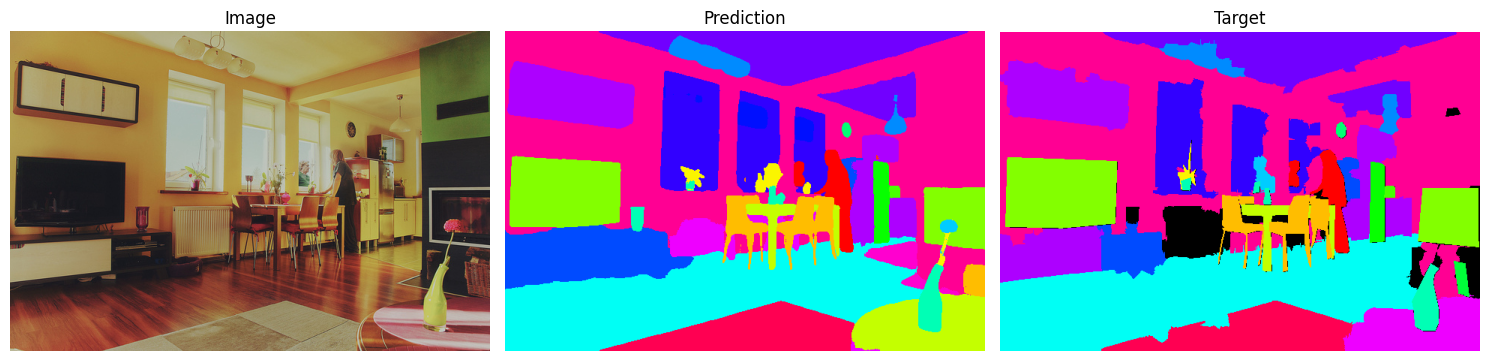

In [5]:
IGNORE_INDEX = 255


def infer_semantic(img, target):
    with torch.no_grad(), autocast(dtype=torch.float16, device_type="cuda"):
        imgs = [img.to(device)]
        img_sizes = [img.shape[-2:] for img in imgs]
        crops, origins = model.window_imgs_semantic(imgs)

        mask_logits_per_layer, class_logits_per_layer = model(crops)
        mask_logits = F.interpolate(mask_logits_per_layer[-1], data.img_size, mode="bilinear")

        crop_logits = model.to_per_pixel_logits_semantic(
            mask_logits, class_logits_per_layer[-1]
        )
        logits = model.revert_window_logits_semantic(crop_logits, origins, img_sizes)
        preds = logits[0].argmax(0).cpu()

    pred_array = preds.numpy()
    target_array = model.to_per_pixel_targets_semantic([target], IGNORE_INDEX)[0].numpy()
    return pred_array, target_array


def plot_semantic_results(img, pred_array, target_array):
    mapping = create_mapping([pred_array, target_array], IGNORE_INDEX)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Image")
    axes[1].imshow(apply_colormap(pred_array, mapping))
    axes[1].set_title("Prediction")
    axes[2].imshow(apply_colormap(target_array, mapping))
    axes[2].set_title("Target")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


img, target = data.val_dataloader().dataset[img_idx]
pred_array, target_array = infer_semantic(img, target)
plot_semantic_results(img, pred_array, target_array)

## Panoptic inference (segmentation with instance IDs)

> This inference method also works when applied to a model trained for instance segmentation.

Panoptic inference assigns each pixel $[h, w]$ to the query $i$ that maximizes the product of class and mask confidence:

$$
p_i(c_i) \cdot m_i[h, w]
$$

where $c_i = \arg\max_c \, p_i(c)$ is the most likely class for query $i$. A pixel is assigned to a query only if both the class confidence and mask confidence are high. Pixels assigned to the same query form a segment labeled with $c_i$. "Stuff" segments with the same class are merged; "thing" segments are kept distinct using the query index. Low-confidence and heavily occluded predictions are filtered out.  
  
*This inference method was originally introduced in MaskFormer.*

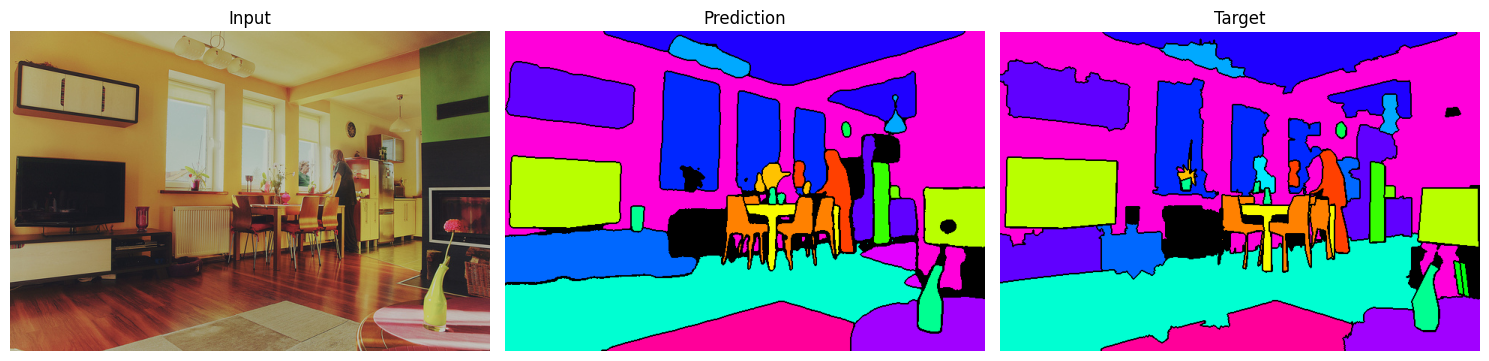

In [6]:
def infer_panoptic(img, target):
    with torch.no_grad(), autocast(dtype=torch.float16, device_type="cuda"):
        imgs = [img.to(device)]
        img_sizes = [img.shape[-2:] for img in imgs]

        transformed_imgs = model.resize_and_pad_imgs_instance_panoptic(imgs)
        mask_logits_per_layer, class_logits_per_layer = model(transformed_imgs)
        mask_logits = F.interpolate(mask_logits_per_layer[-1], model.img_size, mode="bilinear")
        mask_logits = model.revert_resize_and_pad_logits_instance_panoptic(mask_logits, img_sizes)

        preds = model.to_per_pixel_preds_panoptic(
            mask_logits,
            class_logits_per_layer[-1],
            model.stuff_classes,
            model.mask_thresh,
            model.overlap_thresh,
        )[0].cpu()

    pred = preds.numpy()
    sem_pred, inst_pred = pred[..., 0], pred[..., 1]

    target_seg = model.to_per_pixel_targets_panoptic([target])[0].cpu().numpy()
    sem_target, inst_target = target_seg[..., 0], target_seg[..., 1]

    return sem_pred, inst_pred, sem_target, inst_target


def draw_black_border(sem, inst, mapping):
    h, w = sem.shape
    out = np.zeros((h, w, 3))
    for s in np.unique(sem):
        out[sem == s] = mapping[s]

    combined = sem.astype(np.int64) * 100000 + inst.astype(np.int64)
    border = np.zeros((h, w), dtype=bool)
    border[1:, :] |= combined[1:, :] != combined[:-1, :]
    border[:-1, :] |= combined[1:, :] != combined[:-1, :]
    border[:, 1:] |= combined[:, 1:] != combined[:, :-1]
    border[:, :-1] |= combined[:, 1:] != combined[:, :-1]
    out[border] = 0
    return out


def plot_panoptic_results(img, sem_pred, inst_pred, sem_target, inst_target):
    all_ids = np.union1d(np.unique(sem_pred), np.unique(sem_target))
    mapping = {
        s: ([0, 0, 0] if s == -1 or s == model.num_classes else plt.cm.hsv(i / len(all_ids))[:3])
        for i, s in enumerate(all_ids)
    }

    vis_pred = draw_black_border(sem_pred, inst_pred, mapping)
    vis_target = draw_black_border(sem_target, inst_target, mapping)

    img_np = img.cpu().numpy().transpose(1, 2, 0) if img.dim() == 3 else img.cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_np)
    axes[0].set_title("Input")
    axes[1].imshow(vis_pred)
    axes[1].set_title("Prediction")
    axes[2].imshow(vis_target)
    axes[2].set_title("Target")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


img, target = data.val_dataloader().dataset[img_idx]
sem_pred, inst_pred, sem_target, inst_target = infer_panoptic(img, target)
plot_panoptic_results(img, sem_pred, inst_pred, sem_target, inst_target)

In [3]:
# 在notebook的第一个cell中运行
import sys
sys.path.append('/home/dockeruser/ybai_ws/eomt')

# 在第二个cell中运行
from training.lightning_module import LightningModule
import torch

checkpoint_path = "/home/dockeruser/ybai_ws/eomt/eomt/ld2m4a2t/checkpoints/last.ckpt"

lightning_module = LightningModule.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    map_location="cuda" if torch.cuda.is_available() else "cpu"
)

lightning_module.eval()
print("模型加载完成！")

ArgumentError: Parser key "module.network":
  Problem with given class_path 'models.eomt.EoMT':
    Parser key "encoder":
      Problem with given class_path 'models.vit.ViT':
        Validation failed: Key "img_size" is required but not included in config object or its value is None.

In [ ]:
import sys
import os
import torch

# 设置项目路径
project_root = "/home/dockeruser/ybai_ws/eomt"
sys.path.insert(0, project_root)

from training.mask_classification_panoptic import MaskClassificationPanoptic
from models.eomt import EoMT
from models.vit import ViT

def create_model_with_correct_config():
    """根据配置文件创建正确的模型"""
    
    # 根据配置文件创建ViT编码器
    vit_encoder = ViT(
        backbone_name="vit_base_patch14_reg4_dinov2",
        img_size=[640, 640]
        # ViT会根据backbone_name自动设置其他参数
    )
    
    # 创建EoMT网络
    network = EoMT(
        num_classes=2,
        num_q=200,        # 从配置文件中获取
        num_blocks=3,     # 从配置文件中获取
        encoder=vit_encoder
    )
    
    # stuff_classes从配置文件中获取
    stuff_classes = [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
    
    # 创建MaskClassificationPanoptic模型
    lightning_module = MaskClassificationPanoptic(
        network=network,
        attn_mask_annealing_enabled=True,
        attn_mask_annealing_start_steps=[14782, 36955, 59128],
        attn_mask_annealing_end_steps=[29564, 51737, 73910],
        img_size=[640, 640],
        num_classes=2,
        stuff_classes=stuff_classes,
        # 可能还需要其他参数，比如学习率等
        # 这些参数通常有默认值
    )
    
    # 设置stuff_classes属性（用于可视化）
    lightning_module.stuff_classes = stuff_classes
    
    return lightning_module

def load_checkpoint_weights(lightning_module, checkpoint_path):
    """加载checkpoint权重"""
    try:
        print(f"正在加载checkpoint: {checkpoint_path}")
        
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint
            
        # 清理键名
        cleaned_state_dict = {}
        for key, value in state_dict.items():
            clean_key = key.replace('._orig_mod', '').replace('module.', '')
            cleaned_state_dict[clean_key] = value
        
        # 加载权重
        missing_keys, unexpected_keys = lightning_module.load_state_dict(
            cleaned_state_dict, strict=False
        )
        
        print(f"✅ 权重加载完成")
        if missing_keys:
            print(f"⚠️ 缺失 {len(missing_keys)} 个键")
        if unexpected_keys:
            print(f"⚠️ 多余 {len(unexpected_keys)} 个键")
            
        return True
        
    except Exception as e:
        print(f"❌ 加载权重失败: {e}")
        return False

def load_model_for_inference():
    """完整的模型加载流程"""
    
    checkpoint_path = "/home/dockeruser/ybai_ws/eomt/eomt/ld2m4a2t/checkpoints/last.ckpt"
    
    if not os.path.exists(checkpoint_path):
        print(f"❌ Checkpoint文件不存在: {checkpoint_path}")
        return None
    
    try:
        print("正在创建模型...")
        lightning_module = create_model_with_correct_config()
        
        if load_checkpoint_weights(lightning_module, checkpoint_path):
            lightning_module.eval()
            
            device = "cuda" if torch.cuda.is_available() else "cpu"
            lightning_module = lightning_module.to(device)
            
            print(f"✅ 模型已准备就绪，设备: {device}")
            return lightning_module
        else:
            return None
            
    except Exception as e:
        print(f"❌ 创建模型失败: {e}")
        import traceback
        traceback.print_exc()
        return None


model = load_model_for_inference()

if model is not None:
    print("🎉 模型加载成功！")
    
    # 检查是否有推理函数
    if hasattr(model, 'inference_and_visualize'):
        print("✅ 推理函数可用")
    elif hasattr(model, 'plot_panoptic'):
        print("✅ 可视化函数可用")
    else:
        print("ℹ️ 需要添加推理函数")
        
    print("模型信息:")
    print(f"- 查询数量: {model.network.num_q}")
    print(f"- 预测块数量: {model.network.num_blocks}")
    print(f"- Stuff类别数量: {len(model.stuff_classes)}")

    
else:
    print("❌ 模型加载失败")

正在创建模型...


/home/dockeruser/miniconda3/envs/clip/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['network'])`.


正在加载checkpoint: /home/dockeruser/ybai_ws/eomt/eomt/ld2m4a2t/checkpoints/last.ckpt
✅ 权重加载完成
✅ 模型已准备就绪，设备: cuda
🎉 模型加载成功！
✅ 推理函数可用
模型信息:
- 查询数量: 200
- 预测块数量: 3
- Stuff类别数量: 53


正在创建验证数据加载器...
img_files: 241690
img_files: /home/host_ssd/coconut_dataset/coco/train2017/000000372934.jpg
共找到 241521 张图片用于训练
img_files: 5000
img_files: /home/host_ssd/coconut_dataset/coco/val2017/000000300659.jpg
共找到 4996 张图片用于训练
✅ 数据加载器创建成功
获取到batch，图像数量: 8
输入形状: torch.Size([8, 3, 640, 640])
正在进行前向推理...
开始可视化 2 个样本...
可视化样本 1/2
图像已保存到: inference_result_sample_0.png


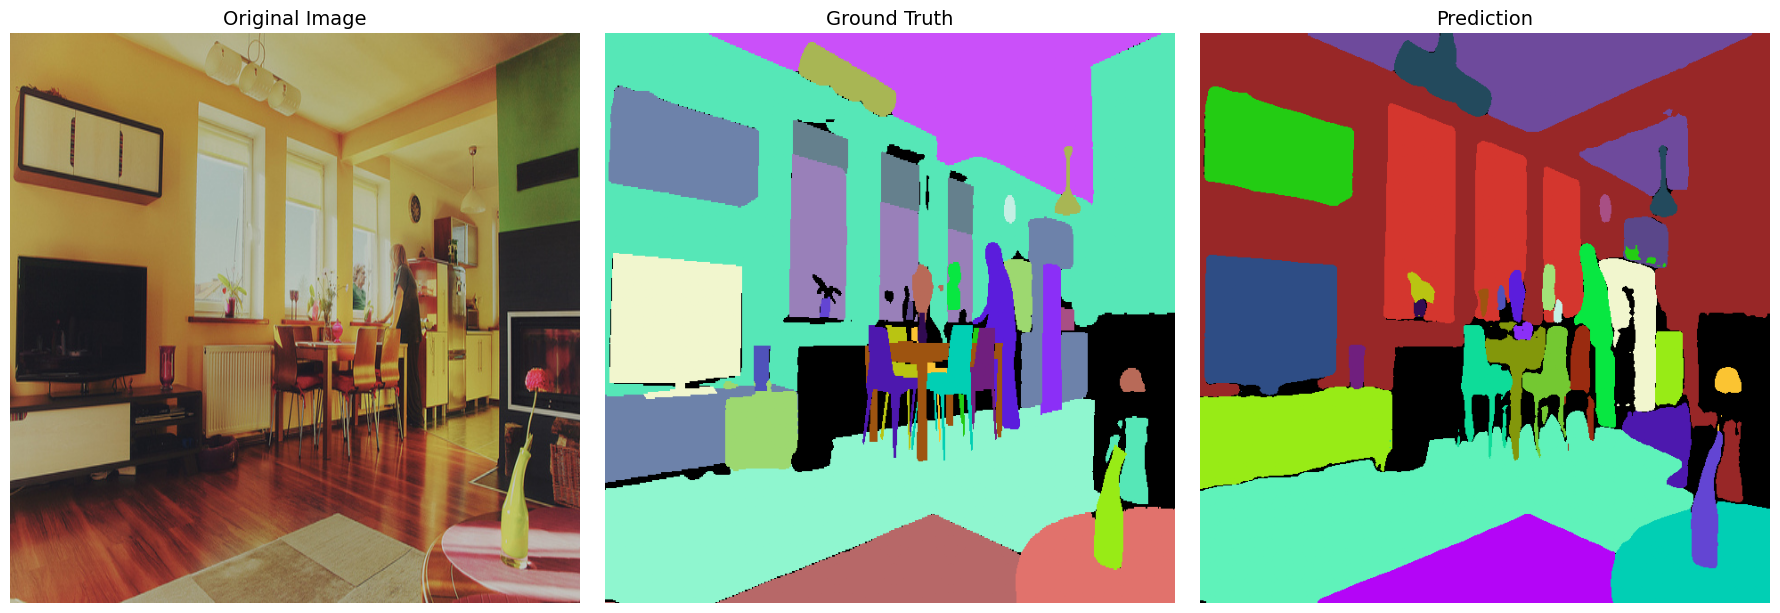

可视化样本 2/2
图像已保存到: inference_result_sample_1.png


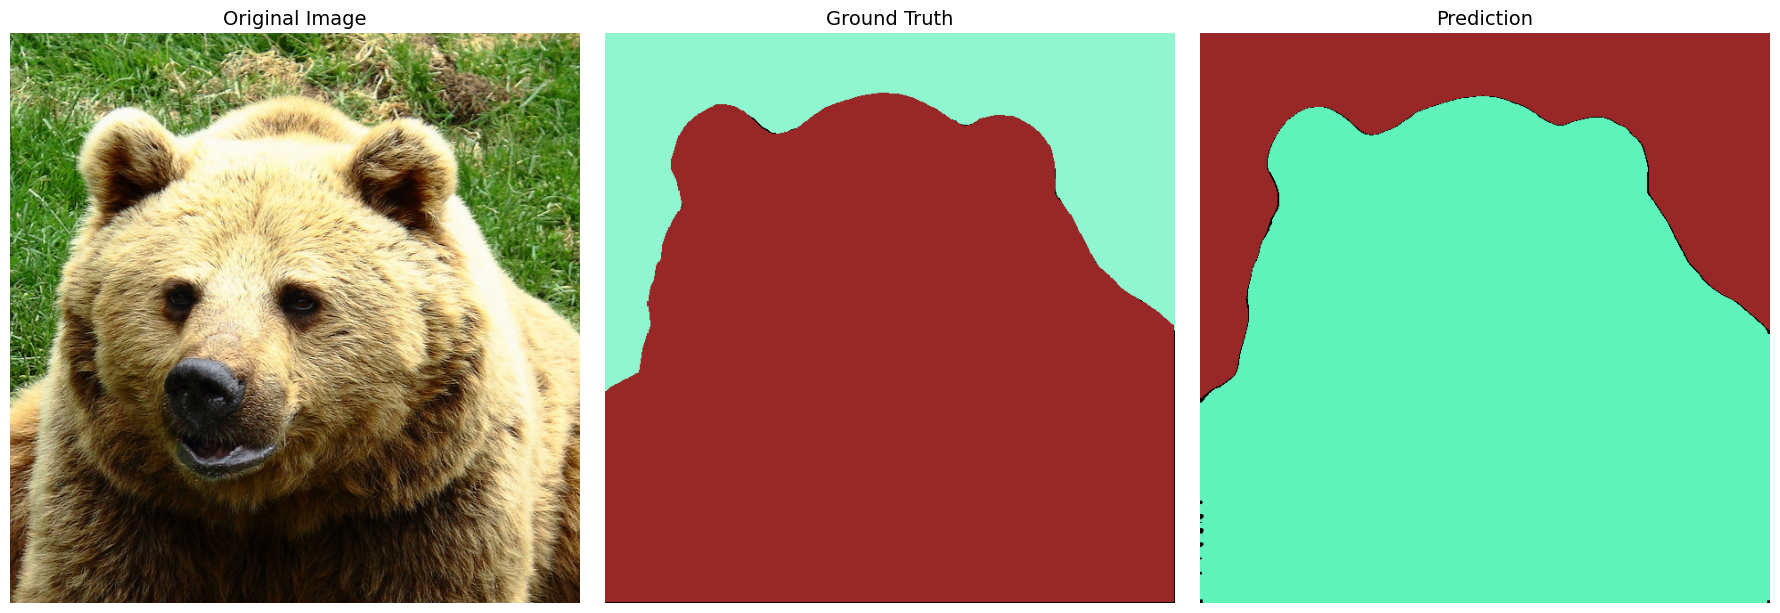

✅ 可视化完成！处理了 2 个样本
🎉 推理完成！


In [14]:
import sys
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
# 设置项目路径
project_root = "/home/dockeruser/ybai_ws/eomt"
sys.path.insert(0, project_root)

# 创建验证数据加载器的函数
def create_validation_dataloader():
    """创建验证数据加载器"""
    from datasets.coco_panoptic_directory import COCOPanopticDirectory
    
    # 创建COCO Panoptic数据集
    dataset = COCOPanopticDirectory(
        stuff_classes=[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132],
        batch_size=8,
        num_workers=8,
        path="/home/host_ssd/coconut_dataset/coco",
        # 您可能需要根据实际情况调整其他参数，比如数据路径等
    )
    
    # 创建验证数据加载器
    dataset.setup()
    val_dataloader = dataset.val_dataloader()
    # val_dataloader = DataLoader(
    #     dataset.val_dataset,  # 或者 dataset.test_dataset，取决于您的需求
    #     batch_size=4,  # 可以调整batch size
    #     shuffle=False,
    #     num_workers=2,
    #     collate_fn=dataset.collate_fn if hasattr(dataset, 'collate_fn') else None
    # )
    
    return val_dataloader

# 修改后的推理函数
def inference_and_visualize_standalone(model, dataloader=None, num_samples=4):
    """
    独立的推理和可视化函数，不依赖trainer
    """
    model.eval()
    
    # 如果没有提供数据加载器，尝试创建一个
    if dataloader is None:
        try:
            print("正在创建验证数据加载器...")
            dataloader = create_validation_dataloader()
            print("✅ 数据加载器创建成功")
        except Exception as e:
            print(f"❌ 创建数据加载器失败: {e}")
            print("请手动提供数据加载器")
            return None
    
    device = next(model.parameters()).device
    
    with torch.no_grad():
        try:
            # 获取一个batch的数据
            batch_iter = iter(dataloader)
            batch = next(batch_iter)
            imgs, targets = batch
            
            print(f"获取到batch，图像数量: {len(imgs) if isinstance(imgs, list) else imgs.shape[0]}")
            
            # 确保数据在正确的设备上
            # if isinstance(imgs, torch.Tensor):
            #     imgs = imgs.to(device)
            # elif isinstance(imgs, list):
            #     imgs = [img.to(device) for img in imgs]
            # 处理输入数据
            if isinstance(imgs, list):
                # 如果是list，转换为tensor
                if len(imgs) > 0 and isinstance(imgs[0], torch.Tensor):
                    imgs = torch.stack(imgs)
                else:
                    print("❌ 无法处理的输入格式")
                    return False
            
            if not isinstance(imgs, torch.Tensor):
                print(f"❌ 输入不是tensor，而是: {type(imgs)}")
                return False
            
            # 移动到设备
            imgs = imgs.to(device)
            print(f"输入形状: {imgs.shape}")

            if isinstance(targets, list):
                for target in targets:
                    if isinstance(target, dict):
                        for key, value in target.items():
                            if isinstance(value, torch.Tensor):
                                target[key] = value.to(device)
            
            print("正在进行前向推理...")
            # 前向推理
            mask_logits_per_block, class_logits_per_block = model(imgs)
            
            # 使用最后一个block的输出
            final_mask_logits = mask_logits_per_block[-1]
            final_class_logits = class_logits_per_block[-1]
            
            # 限制可视化样本数量
            batch_size = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
            num_samples = min(num_samples, batch_size)
            
            print(f"开始可视化 {num_samples} 个样本...")
            
            # 为每个样本进行可视化
            for i in range(num_samples):
                if isinstance(imgs, torch.Tensor):
                    img = imgs[i]
                else:
                    img = imgs[i]
                
                target = targets[i] if isinstance(targets, list) else targets
                mask_logits = final_mask_logits[i]
                class_logits = final_class_logits[i]
                
                print(f"可视化样本 {i+1}/{num_samples}")
                
                # 调用可视化函数
                visualize_panoptic_standalone(
                    model=model,
                    img=img,
                    targets=target,
                    mask_logits=mask_logits,
                    class_logits=class_logits,
                    sample_idx=i
                )
            
            print(f"✅ 可视化完成！处理了 {num_samples} 个样本")
            
            return {
                'mask_logits_per_block': mask_logits_per_block,
                'class_logits_per_block': class_logits_per_block,
                'imgs': imgs,
                'targets': targets
            }
            
        except Exception as e:
            print(f"❌ 推理过程出错: {e}")
            import traceback
            traceback.print_exc()
            return None

def visualize_panoptic_standalone(model, img, targets, mask_logits, class_logits, sample_idx):
    """
    独立的可视化函数，不依赖wandb logger
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import cv2
    from matplotlib.colors import ListedColormap
    
    # 创建图像
    fig, axes = plt.subplots(1, 3, figsize=[18, 6])
    
    # 1. 显示原始图像
    img_np = img.cpu().numpy().transpose(1, 2, 0)
    if img_np.max() <= 1.0:
        img_np = (img_np * 255).astype(np.uint8)
    axes[0].imshow(img_np)
    axes[0].set_title("Original Image", fontsize=14)
    axes[0].axis("off")
    
    # 2. 生成GT panoptic分割图
    gt_panoptic = create_panoptic_visualization_gt(targets, model.stuff_classes)
    axes[1].imshow(gt_panoptic)
    axes[1].set_title("Ground Truth", fontsize=14)
    axes[1].axis("off")
    
    # 3. 生成预测panoptic分割图
    pred_panoptic = create_panoptic_visualization_pred(
        mask_logits, class_logits, img.shape[-2:], model.stuff_classes
    )
    axes[2].imshow(pred_panoptic)
    axes[2].set_title("Prediction", fontsize=14)
    axes[2].axis("off")
    
    plt.tight_layout()
    
    # 保存图像到本地
    save_path = f"inference_result_sample_{sample_idx}.png"
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    print(f"图像已保存到: {save_path}")
    
    # 显示图像
    plt.show()
    plt.close()

def create_panoptic_visualization_gt(targets, stuff_classes):
    """创建GT可视化"""
    H, W = targets["masks"].shape[-2:]
    panoptic_img = np.zeros((H, W, 3), dtype=np.uint8)
    
    np.random.seed(42)
    
    for i, (mask, label) in enumerate(zip(targets["masks"], targets["labels"])):
        if mask.sum() == 0:
            continue
        
        is_thing = label.item() not in stuff_classes
        if is_thing:
            color = (np.random.rand(3) * 255).astype(np.uint8)
        else:
            base_color = np.random.rand(3)
            color = ((base_color * 0.7 + 0.3) * 255).astype(np.uint8)
        
        mask_np = mask.cpu().numpy().astype(bool)
        panoptic_img[mask_np] = color
    
    return panoptic_img.astype(np.float32) / 255.0

def create_panoptic_visualization_pred(mask_logits, class_logits, img_size, stuff_classes):
    """创建预测可视化"""
    H, W = img_size
    panoptic_img = np.zeros((H, W, 3), dtype=np.uint8)
    
    scores, classes = class_logits.softmax(dim=-1).max(-1)
    
    mask_logits_resized = torch.nn.functional.interpolate(
        mask_logits.unsqueeze(0),
        size=(H, W), 
        mode='bilinear', 
        align_corners=False
    )[0]
    
    mask_probs = mask_logits_resized.sigmoid()
    
    # 使用较低的阈值进行调试
    keep = classes.ne(class_logits.shape[-1] - 1) & (scores > 0.1)
    if not keep.any():
        return panoptic_img.astype(np.float32) / 255.0
    
    scores = scores[keep]
    classes = classes[keep]
    mask_probs = mask_probs[keep]
    
    sorted_indices = torch.argsort(scores, descending=True)
    
    np.random.seed(42)
    
    for idx in sorted_indices:
        i = idx.item()
        mask = mask_probs[i] > 0.3
        if mask.sum() == 0:
            continue
        
        class_id = classes[i].item()
        
        is_thing = class_id not in stuff_classes
        if is_thing:
            color = (np.random.rand(3) * 255).astype(np.uint8)
        else:
            base_color = np.random.rand(3)
            color = ((base_color * 0.7 + 0.3) * 255).astype(np.uint8)
        
        mask_np = mask.cpu().numpy().astype(bool)
        panoptic_img[mask_np] = color
    
    return panoptic_img.astype(np.float32) / 255.0

# 使用示例

# 假设您已经加载了模型
# model = load_model_for_inference()  # 使用之前的函数加载模型

# 运行推理和可视化
results = inference_and_visualize_standalone(model, num_samples=2)

if results is not None:
    print("🎉 推理完成！")
else:
    print("❌ 推理失败")